In [1]:
import os, sys
sys.path.append('..') # Parent directory in path
from time import time, sleep
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import statsmodels.api as sm

pd.set_option("display.precision", 4)
#import pandas_market_calendars as mcal # NYSE Calendar

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rc("font", **{"size": 14})
plt.rc("figure", **{"figsize": (16,10)})
# import matplotlib.pylab as pl
from matplotlib import cm

# 1. base data
Daily S&P 500 options data and basic features.

In [4]:
# Import data from methodology_rates_iv
base_data = pd.read_hdf(os.path.join("..", "processed_data", "spx_iv_db.h5"))
base_data.head()

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA
0,2017-07-03,2017-07-21,2430,C,16.4,17.05,17.7,374,6981,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0823,0.0852,0.0882,0.0730,0.5085,0.0103,-0.4882,2.1112
1,2017-07-03,2017-07-21,2430,P,19.9,20.50,21.1,281,6410,2429.01,0.99,0,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0824,0.0852,0.0879,0.0983,-0.4918,0.0077,-0.5551,2.1112
2,2017-07-03,2017-07-21,2425,P,18.0,18.50,19.0,373,38136,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0854,0.0877,0.0900,0.1002,-0.4542,0.0075,-0.5661,2.0977
3,2017-07-03,2017-07-21,2425,C,19.4,20.05,20.7,194,42228,2429.01,4.01,1,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0848,0.0878,0.0908,0.0730,0.5600,0.0102,-0.4877,2.0878
4,2017-07-03,2017-07-21,2435,P,22.2,22.80,23.4,394,8399,2429.01,5.99,2,13,18,0.0211,0.022,0.0138,0.0162,2426.4748,2426.5318,2426.4955,2426.4824,0.022,2426.5318,0.0802,0.0830,0.0858,0.0969,-0.5306,0.0078,-0.5415,2.1055


<AxesSubplot:xlabel='TS'>

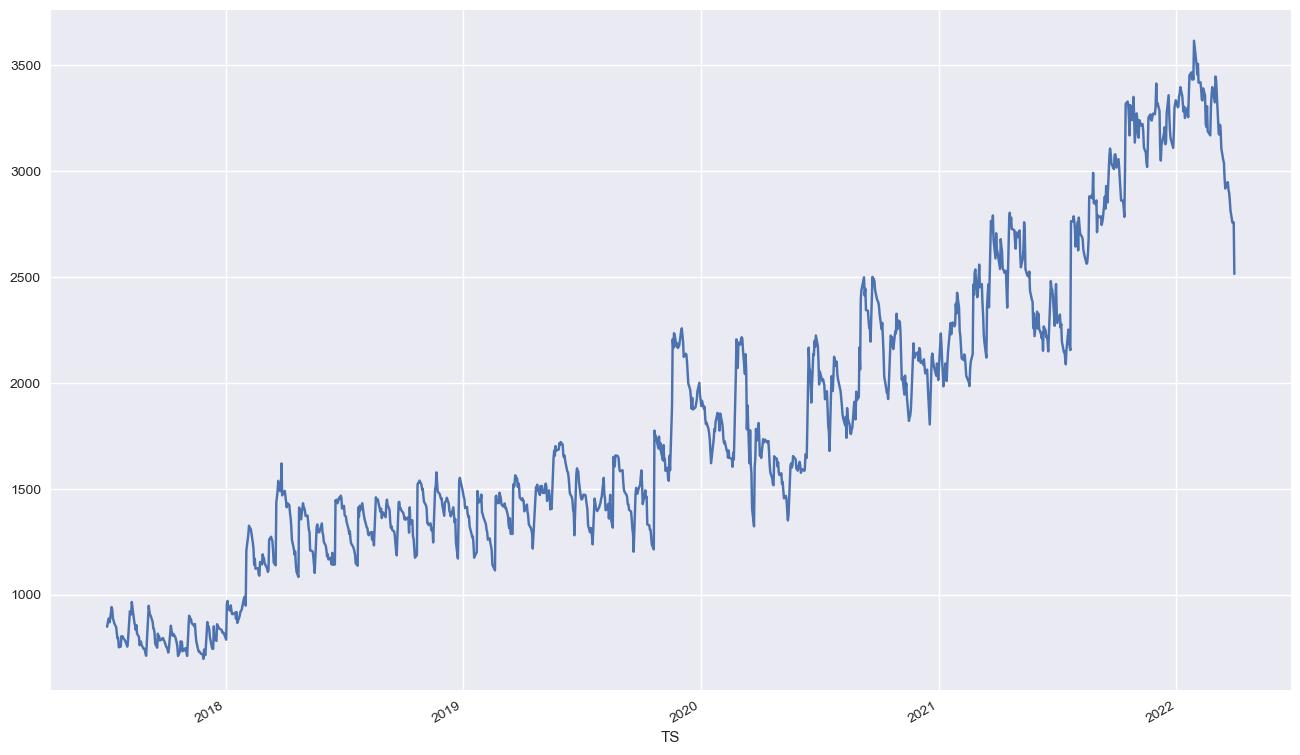

In [5]:
base_data.groupby('TS').count()['TYPE'].plot()

<AxesSubplot:xlabel='BUS_DAYS'>

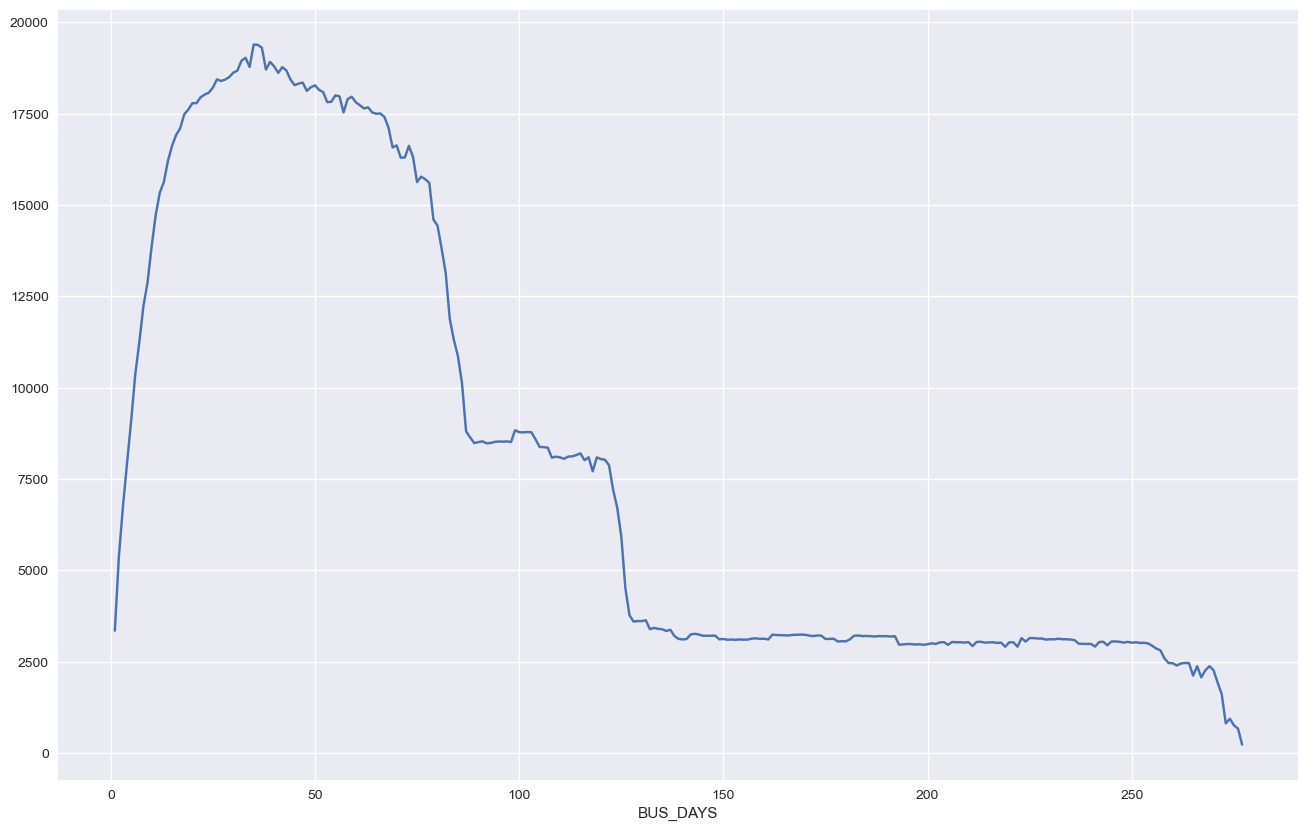

In [6]:
base_data.groupby('BUS_DAYS').count()['TYPE'].plot()

In [7]:
base_data.groupby('BUS_DAYS').count()['TYPE']

BUS_DAYS
1      3349
2      5393
3      6762
4      7949
5      9098
       ... 
273     813
274     940
275     758
276     670
277     232
Name: TYPE, Length: 277, dtype: int64

In [8]:
ts_date = "2022-03-25"
cs_df = base_data[base_data["TS"]==ts_date].reset_index(drop=True)
cs_df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA
0,2022-03-25,2022-04-14,4545,P,72.1,72.75,73.4,76,69,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1627,0.1642,0.1658,0.1687,-0.5026,0.0023,-1.8904,4.1675
1,2022-03-25,2022-04-14,4545,C,66.8,67.40,68.0,67,993,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1624,0.1638,0.1652,0.1673,0.4964,0.0023,-1.7302,4.1675
2,2022-03-25,2022-04-14,4540,P,70.3,70.80,71.3,596,535,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1645,0.1657,0.1668,0.1702,-0.4912,0.0022,-1.9046,4.1667
3,2022-03-25,2022-04-14,4540,C,69.7,70.35,71.0,70,971,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1635,0.1650,0.1665,0.1685,0.5079,0.0023,-1.7411,4.1668
4,2022-03-25,2022-04-14,4550,C,64.0,64.50,65.0,1536,10217,4543.06,6.94,2,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1614,0.1625,0.1637,0.1660,0.4848,0.0023,-1.7168,4.1648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,2022-03-25,2023-03-17,5375,C,49.6,50.45,51.3,0,43,4543.06,831.94,63,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1494,0.1502,0.1511,0.1521,0.1521,0.0003,-0.2297,10.5567
2812,2022-03-25,2023-03-17,5400,P,854.0,862.90,871.8,0,44,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1437,0.1526,0.1609,0.1208,-0.9126,0.0003,-0.0787,7.0304
2813,2022-03-25,2023-03-17,5400,C,46.1,46.85,47.6,0,800,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1488,0.1496,0.1503,0.1514,0.1437,0.0003,-0.2200,10.1621
2814,2022-03-25,2023-03-17,5450,C,39.8,40.60,41.4,0,301,4543.06,906.94,65,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1478,0.1486,0.1495,0.1505,0.1286,0.0003,-0.2026,9.4185


<AxesSubplot:xlabel='BUS_DAYS'>

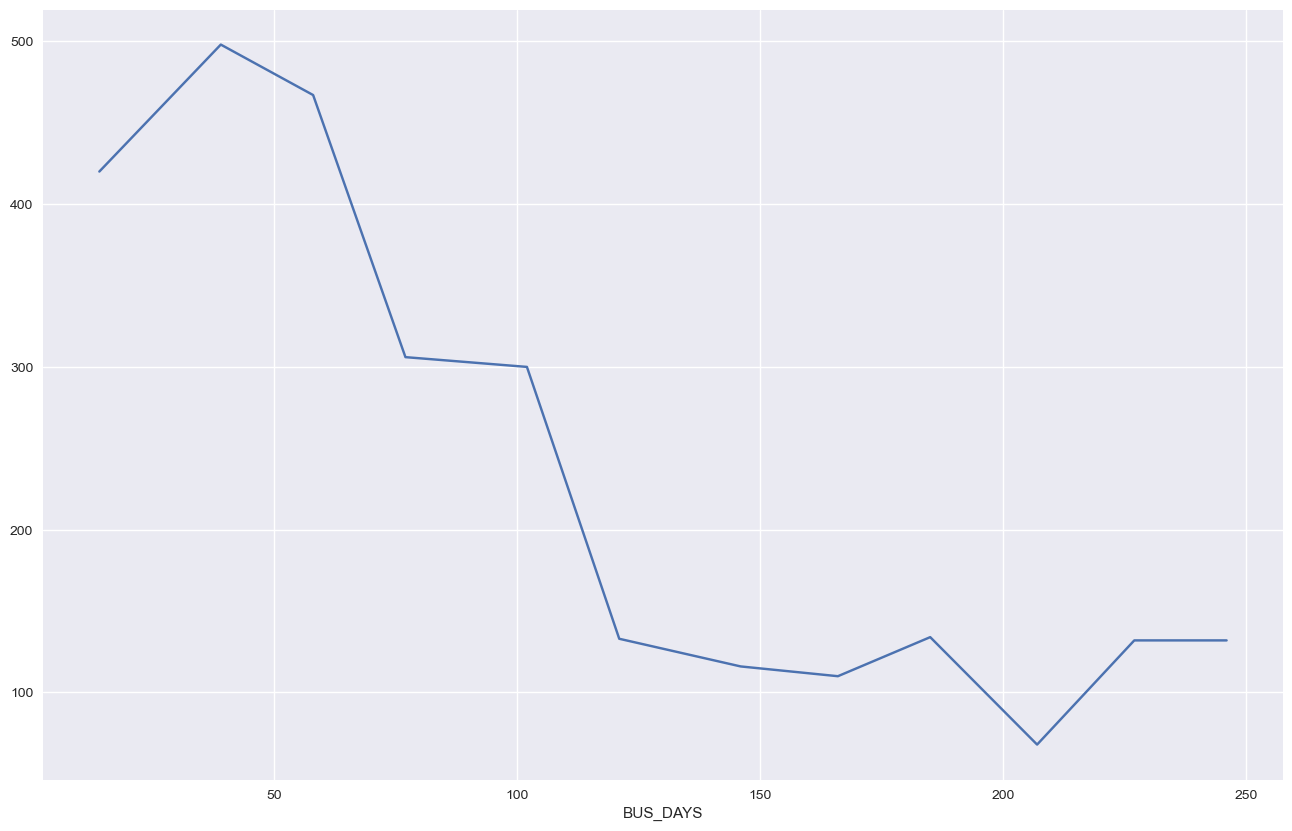

In [9]:
# bus_day = ttm
cs_df.groupby('BUS_DAYS').count()['TYPE'].plot()

In [10]:
# based on single ts cs
ATM_vols = cs_df[cs_df["RANK"]==0]
# compared with atm at same exp
df = pd.merge(cs_df, ATM_vols[["EXP", "TYPE", "IV_BID", "IV_ASK"]], left_on=["EXP", "TYPE"], right_on=["EXP", "TYPE"], 
              suffixes=(None, "_ATM"), how="left")
df["MONEYNESS"] = df["UNDERLYING_PRICE"] - df["STRIKE"]
df["MONEYNESS_F"] = df["STRIKE"]/df["F_T"]
df["LOG_MONEYNESS_F"] = np.log(df["MONEYNESS_F"])
df["LOG_MONEYNESS_F_STANDARD_TIME"] = df["LOG_MONEYNESS_F"] / np.sqrt(df["CAL_DAYS"])

# df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

df["IV_BID_DIFF"] = df["IV_BID"] - df["IV_BID_ATM"]
df["IV_ASK_DIFF"] = df["IV_ASK"] - df["IV_ASK_ATM"]

df["IV_BID_RATIO"] = df["IV_BID"]/df["IV_BID_ATM"]
df["IV_ASK_RATIO"] = df["IV_ASK"]/df["IV_ASK_ATM"]
df["IV_MID_SQR"] = df["IV_MID"]**2
cs_df = df.copy()
cs_df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IV_MID_SQR
0,2022-03-25,2022-04-14,4545,P,72.1,72.75,73.4,76,69,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1627,0.1642,0.1658,0.1687,-0.5026,0.0023,-1.8904,4.1675,0.1627,0.1658,-1.94,1.0011,1.1347e-03,2.5372e-04,0.0000,0.0000,1.0000,1.0000,0.0270
1,2022-03-25,2022-04-14,4545,C,66.8,67.40,68.0,67,993,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1624,0.1638,0.1652,0.1673,0.4964,0.0023,-1.7302,4.1675,0.1624,0.1652,-1.94,1.0011,1.1347e-03,2.5372e-04,0.0000,0.0000,1.0000,1.0000,0.0268
2,2022-03-25,2022-04-14,4540,P,70.3,70.80,71.3,596,535,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1645,0.1657,0.1668,0.1702,-0.4912,0.0022,-1.9046,4.1667,0.1627,0.1658,3.06,1.0000,3.3950e-05,7.5915e-06,0.0018,0.0011,1.0111,1.0066,0.0274
3,2022-03-25,2022-04-14,4540,C,69.7,70.35,71.0,70,971,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1635,0.1650,0.1665,0.1685,0.5079,0.0023,-1.7411,4.1668,0.1624,0.1652,3.06,1.0000,3.3950e-05,7.5915e-06,0.0011,0.0013,1.0068,1.0081,0.0272
4,2022-03-25,2022-04-14,4550,C,64.0,64.50,65.0,1536,10217,4543.06,6.94,2,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1614,0.1625,0.1637,0.1660,0.4848,0.0023,-1.7168,4.1648,0.1624,0.1652,-6.94,1.0022,2.2342e-03,4.9958e-04,-0.0010,-0.0015,0.9939,0.9911,0.0264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,2022-03-25,2023-03-17,5375,C,49.6,50.45,51.3,0,43,4543.06,831.94,63,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1494,0.1502,0.1511,0.1521,0.1521,0.0003,-0.2297,10.5567,0.2062,0.2091,-831.94,1.1757,1.6184e-01,8.5654e-03,-0.0568,-0.0581,0.7248,0.7224,0.0226
2812,2022-03-25,2023-03-17,5400,P,854.0,862.90,871.8,0,44,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1437,0.1526,0.1609,0.1208,-0.9126,0.0003,-0.0787,7.0304,0.2063,0.2090,-856.94,1.1811,1.6648e-01,8.8110e-03,-0.0626,-0.0482,0.6967,0.7696,0.0233
2813,2022-03-25,2023-03-17,5400,C,46.1,46.85,47.6,0,800,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1488,0.1496,0.1503,0.1514,0.1437,0.0003,-0.2200,10.1621,0.2062,0.2091,-856.94,1.1811,1.6648e-01,8.8110e-03,-0.0574,-0.0588,0.7219,0.7189,0.0224
2814,2022-03-25,2023-03-17,5450,C,39.8,40.60,41.4,0,301,4543.06,906.94,65,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1478,0.1486,0.1495,0.1505,0.1286,0.0003,-0.2026,9.4185,0.2062,0.2091,-906.94,1.1921,1.7570e-01,9.2988e-03,-0.0584,-0.0596,0.7167,0.7149,0.0221


#### * Question 1: should we calculate the greeks for every option as features?

# 2.vol curve fit
* hyperbola for example, maybe expand more model in future

Fixed a specific expiration, we can fit a set of vol curves(different DTE), x axis is moneyness, y axis is iv. \
When fitting the curve, we use out-of-the-money data to fit vol curve.


[Hyperbola Equation](https://www.desmos.com/calculator/phvqct3f4b):

$$\begin{aligned}
    y &= \sqrt{b^{2}\left(1+\frac{\left(x-c\right)^{2}}{a^{2}}\right)}+d(x-c) + e
\end{aligned}$$


#### * Question 2: the intuitively financial meaning of a,b,c,d,e?

In [11]:
def hyperbola(x, a, b, c, d, e) -> float:
    """Tiltable hyperbola for scipy.optimize.curve_fit
    Asymptotes at 
    y=(-b/a+d)(x-c)+e
    y=( b/a+d)(x-c)+e"""
    return (b**2*(1+(x-c)**2/a**2))**0.5+d*(x-c)+e

def hyperbola_jac(x, a, b, c, d, e) -> np.ndarray:
    """Jacobian of the hyperbola with respect to each parameter"""
    ru = np.sqrt(b**2*(1+(x-c)**2/a**2))
    da = -(b**2 * (x-c)**2) / (a**3 * ru)
    db = np.sqrt(1+(x-c)**2/a**2)
    dc = -(b**2 * (x-c)) / (a**2 * ru) - d
    dd = x-c
    de = np.ones(len(x))
    return np.array([da, db, dc, dd, de]).T

def hyperbola_minimizer(a, b, c, d, e) -> float:
    """Returns the minimizer (x such that y is the minimum) of a hyperbola"""
    return ((a**2 * c * d**2 + d*(a**4 * b**2 - a**6 * d**2)**0.5 - b**2 * c)
            /(a**2 * d**2 - b**2))

def fit_hyp(df) -> np.ndarray:
    """Fits a hyperbola for a day's IV single curve"""
    curve = df.loc[:,["LOG_MONEYNESS_F","IV_MID"]].dropna()
    bounds = ((1e-4, 1e-4, 0, -2, -2), (1, 1, 1, 2, 2))
    try:
        popt, pcov = curve_fit(hyperbola, curve["LOG_MONEYNESS_F"], curve["IV_MID"]**2, 
                               jac=hyperbola_jac, bounds=bounds, maxfev=5000)
        return popt
    except (RuntimeError, ValueError):
        return np.array([np.nan] * 5)

In [12]:
cs_df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IV_MID_SQR
0,2022-03-25,2022-04-14,4545,P,72.1,72.75,73.4,76,69,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1627,0.1642,0.1658,0.1687,-0.5026,0.0023,-1.8904,4.1675,0.1627,0.1658,-1.94,1.0011,1.1347e-03,2.5372e-04,0.0000,0.0000,1.0000,1.0000,0.0270
1,2022-03-25,2022-04-14,4545,C,66.8,67.40,68.0,67,993,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1624,0.1638,0.1652,0.1673,0.4964,0.0023,-1.7302,4.1675,0.1624,0.1652,-1.94,1.0011,1.1347e-03,2.5372e-04,0.0000,0.0000,1.0000,1.0000,0.0268
2,2022-03-25,2022-04-14,4540,P,70.3,70.80,71.3,596,535,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1645,0.1657,0.1668,0.1702,-0.4912,0.0022,-1.9046,4.1667,0.1627,0.1658,3.06,1.0000,3.3950e-05,7.5915e-06,0.0018,0.0011,1.0111,1.0066,0.0274
3,2022-03-25,2022-04-14,4540,C,69.7,70.35,71.0,70,971,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1635,0.1650,0.1665,0.1685,0.5079,0.0023,-1.7411,4.1668,0.1624,0.1652,3.06,1.0000,3.3950e-05,7.5915e-06,0.0011,0.0013,1.0068,1.0081,0.0272
4,2022-03-25,2022-04-14,4550,C,64.0,64.50,65.0,1536,10217,4543.06,6.94,2,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1614,0.1625,0.1637,0.1660,0.4848,0.0023,-1.7168,4.1648,0.1624,0.1652,-6.94,1.0022,2.2342e-03,4.9958e-04,-0.0010,-0.0015,0.9939,0.9911,0.0264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,2022-03-25,2023-03-17,5375,C,49.6,50.45,51.3,0,43,4543.06,831.94,63,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1494,0.1502,0.1511,0.1521,0.1521,0.0003,-0.2297,10.5567,0.2062,0.2091,-831.94,1.1757,1.6184e-01,8.5654e-03,-0.0568,-0.0581,0.7248,0.7224,0.0226
2812,2022-03-25,2023-03-17,5400,P,854.0,862.90,871.8,0,44,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1437,0.1526,0.1609,0.1208,-0.9126,0.0003,-0.0787,7.0304,0.2063,0.2090,-856.94,1.1811,1.6648e-01,8.8110e-03,-0.0626,-0.0482,0.6967,0.7696,0.0233
2813,2022-03-25,2023-03-17,5400,C,46.1,46.85,47.6,0,800,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1488,0.1496,0.1503,0.1514,0.1437,0.0003,-0.2200,10.1621,0.2062,0.2091,-856.94,1.1811,1.6648e-01,8.8110e-03,-0.0574,-0.0588,0.7219,0.7189,0.0224
2814,2022-03-25,2023-03-17,5450,C,39.8,40.60,41.4,0,301,4543.06,906.94,65,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1478,0.1486,0.1495,0.1505,0.1286,0.0003,-0.2026,9.4185,0.2062,0.2091,-906.94,1.1921,1.7570e-01,9.2988e-03,-0.0584,-0.0596,0.7167,0.7149,0.0221


In [13]:
otm_mask = (((cs_df["TYPE"]=='C') & (cs_df["STRIKE"]>cs_df["UNDERLYING_PRICE"])) 
            | ((cs_df["TYPE"]=='P') & (cs_df["STRIKE"]<=cs_df["UNDERLYING_PRICE"])))

otm  = cs_df[otm_mask].copy().reset_index(drop=True)
to_fit = otm
to_fit

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IV_MID_SQR
0,2022-03-25,2022-04-14,4545,C,66.8,67.40,68.0,67,993,4543.06,1.94,0,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1624,0.1638,0.1652,0.1673,0.4964,0.0023,-1.7302,4.1675,0.1624,0.1652,-1.94,1.0011,1.1347e-03,2.5372e-04,0.0000,0.0000,1.0000,1.0000,0.0268
1,2022-03-25,2022-04-14,4540,P,70.3,70.80,71.3,596,535,4543.06,3.06,1,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1645,0.1657,0.1668,0.1702,-0.4912,0.0022,-1.9046,4.1667,0.1627,0.1658,3.06,1.0000,3.3950e-05,7.5915e-06,0.0018,0.0011,1.0111,1.0066,0.0274
2,2022-03-25,2022-04-14,4550,C,64.0,64.50,65.0,1536,10217,4543.06,6.94,2,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1614,0.1625,0.1637,0.1660,0.4848,0.0023,-1.7168,4.1648,0.1624,0.1652,-6.94,1.0022,2.2342e-03,4.9958e-04,-0.0010,-0.0015,0.9939,0.9911,0.0264
3,2022-03-25,2022-04-14,4535,P,68.2,68.80,69.4,25,141,4543.06,8.06,3,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1655,0.1669,0.1683,0.1714,-0.4800,0.0022,-1.9141,4.1626,0.1627,0.1658,8.06,0.9989,-1.0680e-03,-2.3881e-04,0.0028,0.0025,1.0170,1.0153,0.0278
4,2022-03-25,2022-04-14,4555,C,61.0,61.55,62.1,1,620,4543.06,11.94,4,14,20,0.0020,-1.4517e-05,-0.0062,0.0021,4539.8821,4539.8459,4539.7113,4539.8293,-1.4517e-05,4539.8459,0.1598,0.1611,0.1623,0.1645,0.4730,0.0023,-1.6996,4.1584,0.1624,0.1652,-11.94,1.0033,3.3325e-03,7.4516e-04,-0.0026,-0.0028,0.9840,0.9829,0.0259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,2022-03-25,2023-03-17,5325,C,57.5,58.35,59.2,0,97,4543.06,781.94,61,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1509,0.1517,0.1524,0.1535,0.1697,0.0004,-0.2492,11.3409,0.2062,0.2091,-781.94,1.1647,1.5249e-01,8.0708e-03,-0.0553,-0.0567,0.7318,0.7288,0.0230
1484,2022-03-25,2023-03-17,5350,C,53.4,54.20,55.0,1,666,4543.06,806.94,62,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1501,0.1509,0.1516,0.1527,0.1606,0.0004,-0.2391,10.9418,0.2062,0.2091,-806.94,1.1702,1.5718e-01,8.3186e-03,-0.0561,-0.0575,0.7281,0.7250,0.0228
1485,2022-03-25,2023-03-17,5375,C,49.6,50.45,51.3,0,43,4543.06,831.94,63,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1494,0.1502,0.1511,0.1521,0.1521,0.0003,-0.2297,10.5567,0.2062,0.2091,-831.94,1.1757,1.6184e-01,8.5654e-03,-0.0568,-0.0581,0.7248,0.7224,0.0226
1486,2022-03-25,2023-03-17,5400,C,46.1,46.85,47.6,0,800,4543.06,856.94,64,246,357,0.0189,1.8946e-02,0.0188,0.0191,4571.8120,4571.8611,4572.0076,4571.8519,1.8946e-02,4571.8611,0.1488,0.1496,0.1503,0.1514,0.1437,0.0003,-0.2200,10.1621,0.2062,0.2091,-856.94,1.1811,1.6648e-01,8.8110e-03,-0.0574,-0.0588,0.7219,0.7189,0.0224


<AxesSubplot:xlabel='BUS_DAYS'>

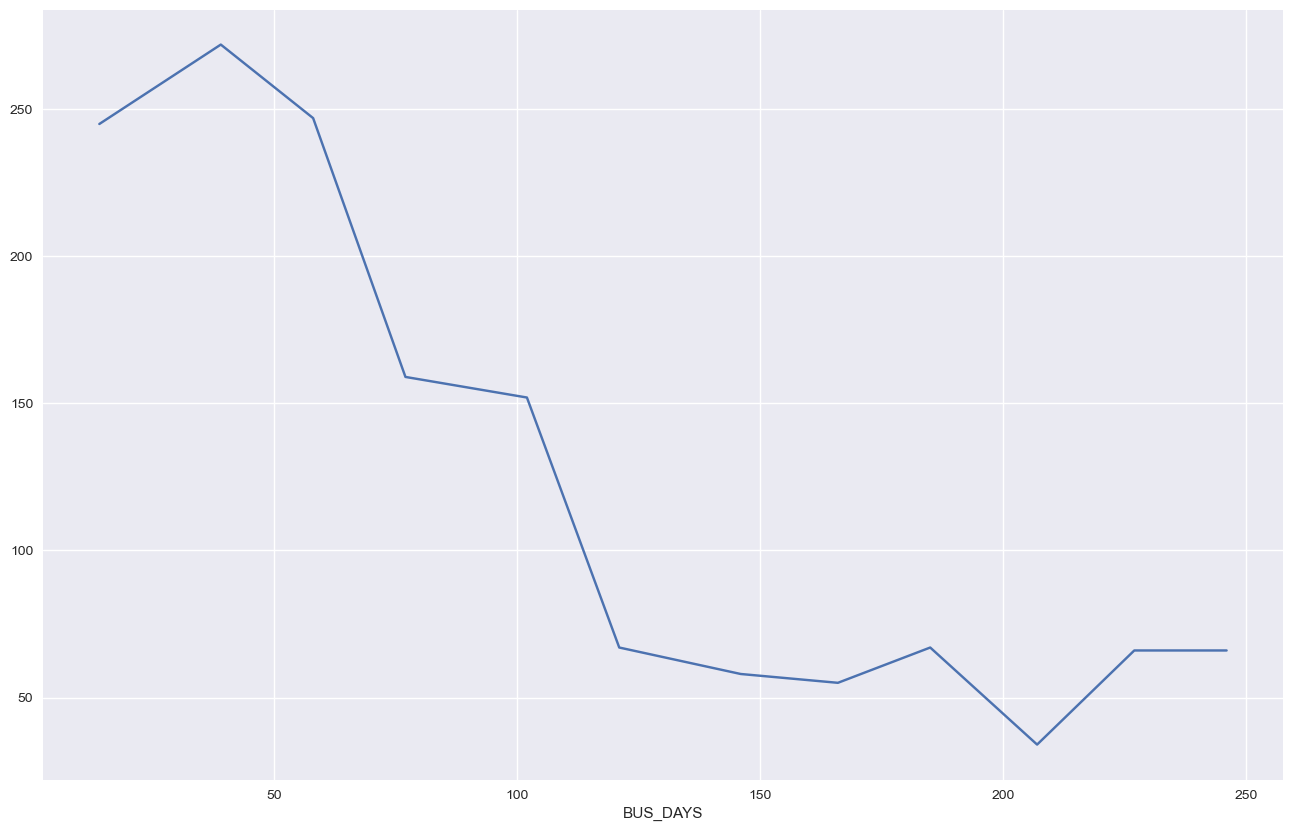

In [14]:
to_fit.groupby('BUS_DAYS').count()['TYPE'].plot()

In [15]:
fits = to_fit.groupby("BUS_DAYS").apply(fit_hyp)
fits = np.array([v for v in fits.values])

fit_df = pd.DataFrame(fits, index=to_fit["BUS_DAYS"].unique(), columns=['a', 'b', 'c', 'd', 'e'])
fit_df

,a,b,c,d,e
14,0.1962,0.6135,0.2241,2.0000,-0.4559
39,0.0397,0.0097,0.0537,-0.1285,0.0093
58,0.0351,0.0069,0.0628,-0.1244,0.0136
77,0.0364,0.0061,0.0688,-0.1249,0.0151
102,0.0365,0.0051,0.0803,-0.1204,0.0167
121,0.0421,0.0054,0.0895,-0.1147,0.0169
146,0.0396,0.0041,0.0939,-0.1168,0.0190
166,0.0368,0.0033,0.0969,-0.1166,0.0208
185,0.0425,0.0038,0.1050,-0.1069,0.0202
207,0.0472,0.0040,0.1079,-0.1026,0.0206


<AxesSubplot:xlabel='index', ylabel='e'>

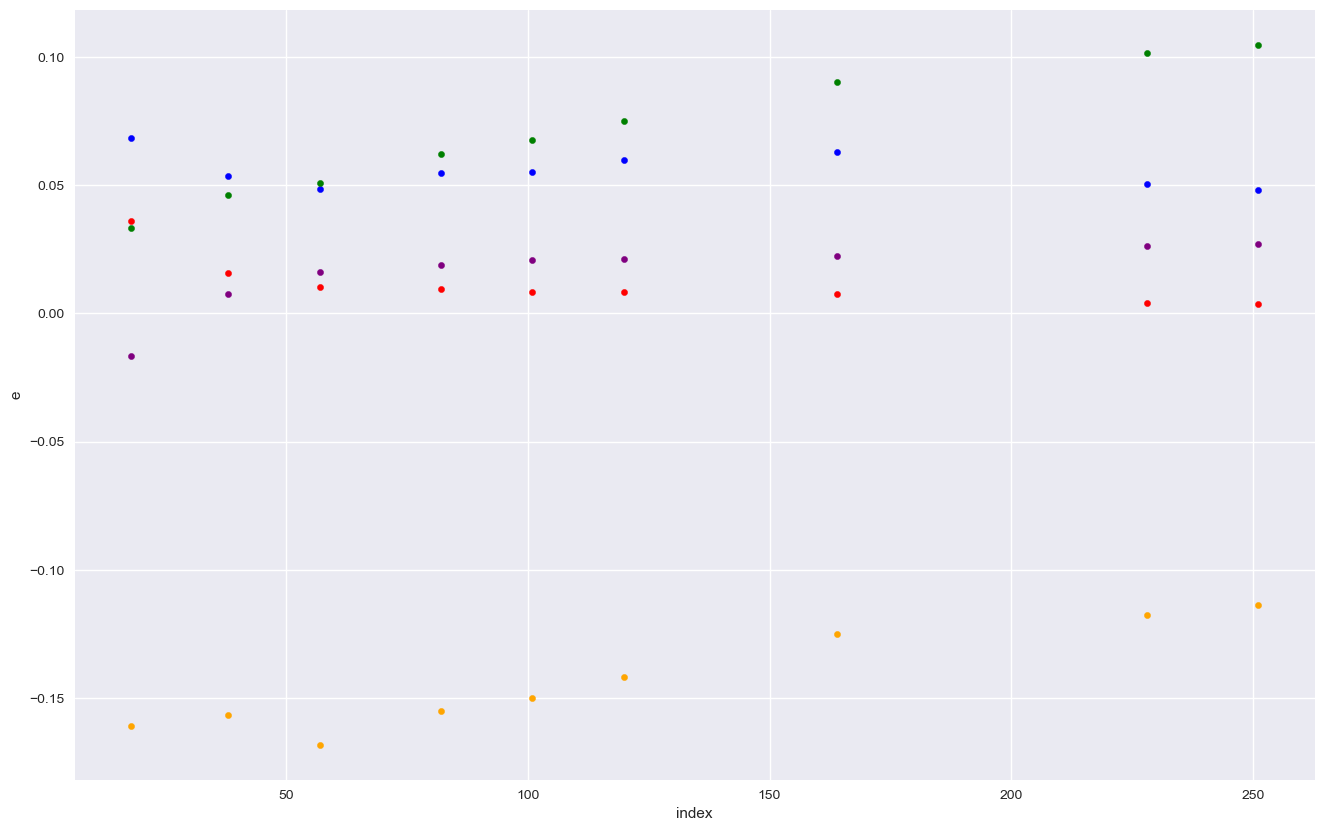

In [17]:
pl = fit_df.copy()
pl = pl.reset_index()
ax = pl.plot(kind="scatter", x="index",y="a", color="b")
pl.plot(kind="scatter", x="index",y="b", color="r", ax=ax)
pl.plot(kind="scatter", x="index",y="c", color="g", ax=ax)
pl.plot(kind="scatter", x="index",y="d", color="orange", ax=ax)
pl.plot(kind="scatter", x="index",y="e", color="purple", ax=ax)

In [18]:
ttm_list = list(cs_df['BUS_DAYS'].unique())
for ttm in ttm_list:
    param = fit_df[fit_df.index==ttm].values[0]
    cs_df.loc[cs_df['BUS_DAYS']==ttm,'hyperbola_vol'] = cs_df.loc[cs_df['BUS_DAYS']==ttm,'LOG_MONEYNESS_F'].apply(lambda x:
                                                np.sqrt(hyperbola(x, param[0], param[1], param[2], param[3], param[4])))
cs_df

,TS,EXP,STRIKE,TYPE,BID_CLOSE,MID_CLOSE,ASK_CLOSE,VOLUME,OPEN_INT,UNDERLYING_PRICE,DIFF,RANK,BUS_DAYS,CAL_DAYS,RATE_OLS,RATE_OPEN_INT,RATE_VOLUME,RATE_MONEYNESS,F_T_OLS,F_T_OPEN_INT,F_T_VOLUME,F_T_MONEYNESS,RATE,F_T,IV_BID,IV_MID,IV_ASK,IMP_VOLATILITY,DELTA,GAMMA,THETA,VEGA,IV_BID_ATM,IV_ASK_ATM,MONEYNESS,MONEYNESS_F,LOG_MONEYNESS_F,LOG_MONEYNESS_F_STANDARD_TIME,IV_BID_DIFF,IV_ASK_DIFF,IV_BID_RATIO,IV_ASK_RATIO,IV_MID_SQR,hyperbola_vol
0,2021-01-25,2021-02-19,3855,P,69.5,70.00,70.5,20,143,3855.36,0.36,0,18,25,0.0057,0.0058,0.0141,0.0105,3851.8990,3851.8181,3851.8573,3851.8682,0.0058,3851.8181,0.1653,0.1666,0.1678,0.1731,-0.4966,0.0023,-1.4709,3.9675,0.1653,0.1678,0.36,1.0008,0.0008,1.6515e-04,0.0000,0.0000,1.0000,1.0000,0.0277,0.1679
1,2021-01-25,2021-02-19,3855,C,66.3,66.70,67.1,14,554,3855.36,0.36,0,18,25,0.0057,0.0058,0.0141,0.0105,3851.8990,3851.8181,3851.8573,3851.8682,0.0058,3851.8181,0.1653,0.1663,0.1672,0.1468,0.5000,0.0027,-1.1358,3.9676,0.1653,0.1672,0.36,1.0008,0.0008,1.6515e-04,0.0000,0.0000,1.0000,1.0000,0.0276,0.1679
2,2021-01-25,2021-02-19,3860,P,71.5,71.95,72.4,5,309,3855.36,4.64,1,18,25,0.0057,0.0058,0.0141,0.0105,3851.8990,3851.8181,3851.8573,3851.8682,0.0058,3851.8181,0.1639,0.1650,0.1660,0.1715,-0.5084,0.0023,-1.4589,3.9666,0.1653,0.1678,-4.64,1.0021,0.0021,4.2438e-04,-0.0015,-0.0017,0.9910,0.9897,0.0272,0.1664
3,2021-01-25,2021-02-19,3860,C,63.5,63.85,64.2,15,655,3855.36,4.64,1,18,25,0.0057,0.0058,0.0141,0.0105,3851.8990,3851.8181,3851.8573,3851.8682,0.0058,3851.8181,0.1643,0.1651,0.1660,0.1468,0.4864,0.0027,-1.1368,3.9654,0.1653,0.1672,-4.64,1.0021,0.0021,4.2438e-04,-0.0010,-0.0012,0.9939,0.9926,0.0273,0.1664
4,2021-01-25,2021-02-19,3850,P,67.6,68.10,68.6,665,3912,3855.36,5.36,2,18,25,0.0057,0.0058,0.0141,0.0105,3851.8990,3851.8181,3851.8573,3851.8682,0.0058,3851.8181,0.1669,0.1681,0.1694,0.1747,-0.4850,0.0023,-1.4816,3.9649,0.1653,0.1678,5.36,0.9995,-0.0005,-9.4423e-05,0.0016,0.0016,1.0096,1.0095,0.0283,0.1694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-01-25,2022-01-21,3225,P,161.9,163.70,165.5,0,154,3855.36,630.36,48,251,361,0.0050,0.0049,0.0051,0.0049,3816.3517,3816.3730,3816.4120,3816.3372,0.0049,3816.3730,0.2790,0.2806,0.2822,0.2813,-0.2264,0.0003,-0.4719,11.4658,0.2127,0.2159,630.36,0.8450,-0.1684,-8.8615e-03,0.0663,0.0663,1.3115,1.3071,0.0787,0.2814
2263,2021-01-25,2022-01-21,4500,P,727.4,732.30,737.2,0,2,3855.36,644.64,49,251,361,0.0050,0.0049,0.0051,0.0049,3816.3517,3816.3730,3816.4120,3816.3372,0.0049,3816.3730,0.1554,0.1605,0.1655,0.1581,-0.8240,0.0004,-0.2941,9.4020,0.2127,0.2159,-644.64,1.1791,0.1648,8.6725e-03,-0.0574,-0.0503,0.7303,0.7669,0.0258,0.1612
2264,2021-01-25,2022-01-21,4500,C,50.7,52.15,53.6,36,296,3855.36,644.64,49,251,361,0.0050,0.0049,0.0051,0.0049,3816.3517,3816.3730,3816.4120,3816.3372,0.0049,3816.3730,0.1592,0.1607,0.1622,0.1615,0.1692,0.0004,-0.1962,9.6196,0.2125,0.2162,-644.64,1.1791,0.1648,8.6725e-03,-0.0534,-0.0540,0.7489,0.7502,0.0258,0.1612
2265,2021-01-25,2022-01-21,4600,C,37.1,38.35,39.6,60,283,3855.36,744.64,50,251,361,0.0050,0.0049,0.0051,0.0049,3816.3517,3816.3730,3816.4120,3816.3372,0.0049,3816.3730,0.1569,0.1584,0.1599,0.1593,0.1333,0.0004,-0.1663,8.2125,0.2125,0.2162,-744.64,1.2053,0.1868,9.8293e-03,-0.0556,-0.0562,0.7382,0.7398,0.0251,0.1577


<AxesSubplot:xlabel='index', ylabel='hyperbola_vol'>

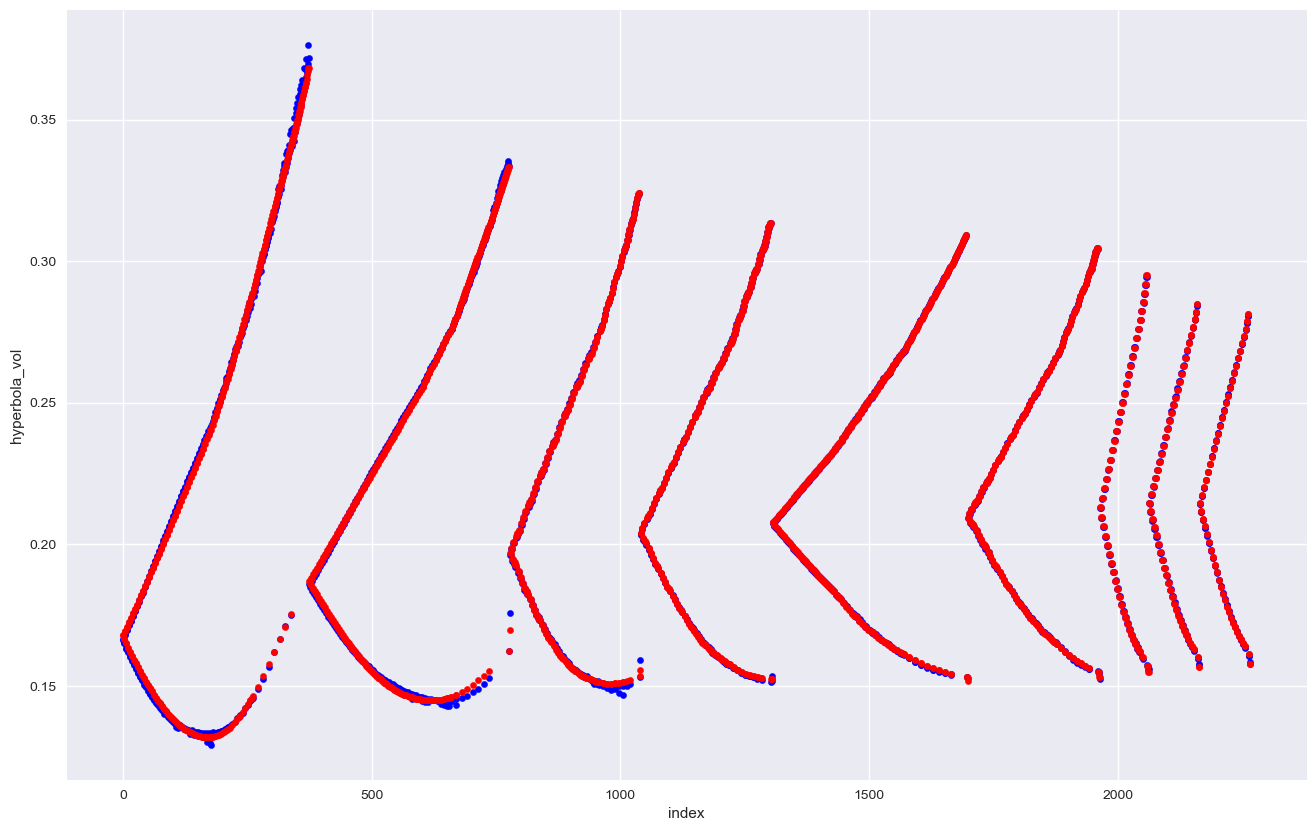

In [19]:
pl = cs_df.copy()
pl = pl.reset_index()
ax = pl.plot(kind="scatter", x="index",y="IV_MID", color="b")
pl.plot(kind="scatter", x="index",y="hyperbola_vol", color="r", ax=ax)

In [20]:
def black76(F,K,T,r,sigma,type):
    """Black Model 1976"""
    d1=(np.log(F/K)+(sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2=d1-(sigma*np.sqrt(T))
    B_call=np.exp(-r*T)*(F*stats.norm.cdf(d1)-K*stats.norm.cdf(d2))
    B_put=np.exp(-r*T)*(K*stats.norm.cdf(-d2)-F*stats.norm.cdf(-d1))
    return (type=='C')*B_call + (type=='P')*B_put

In [21]:
F = cs_df["F_T"].astype(float).values
K = cs_df['STRIKE'].astype(float).values
r = cs_df['RATE'].astype(float).values
T = cs_df['BUS_DAYS'].astype(float).values/252
typee = cs_df['TYPE'].values
h_vol = cs_df['hyperbola_vol'].astype(float).values
iv = cs_df['IV_MID'].astype(float).values

cs_df["hyperbola_price"] = black76(F,K,T,r,h_vol,typee)
cs_df["implied_price"] = black76(F,K,T,r,iv,typee)

<AxesSubplot:xlabel='index', ylabel='hyperbola_price'>

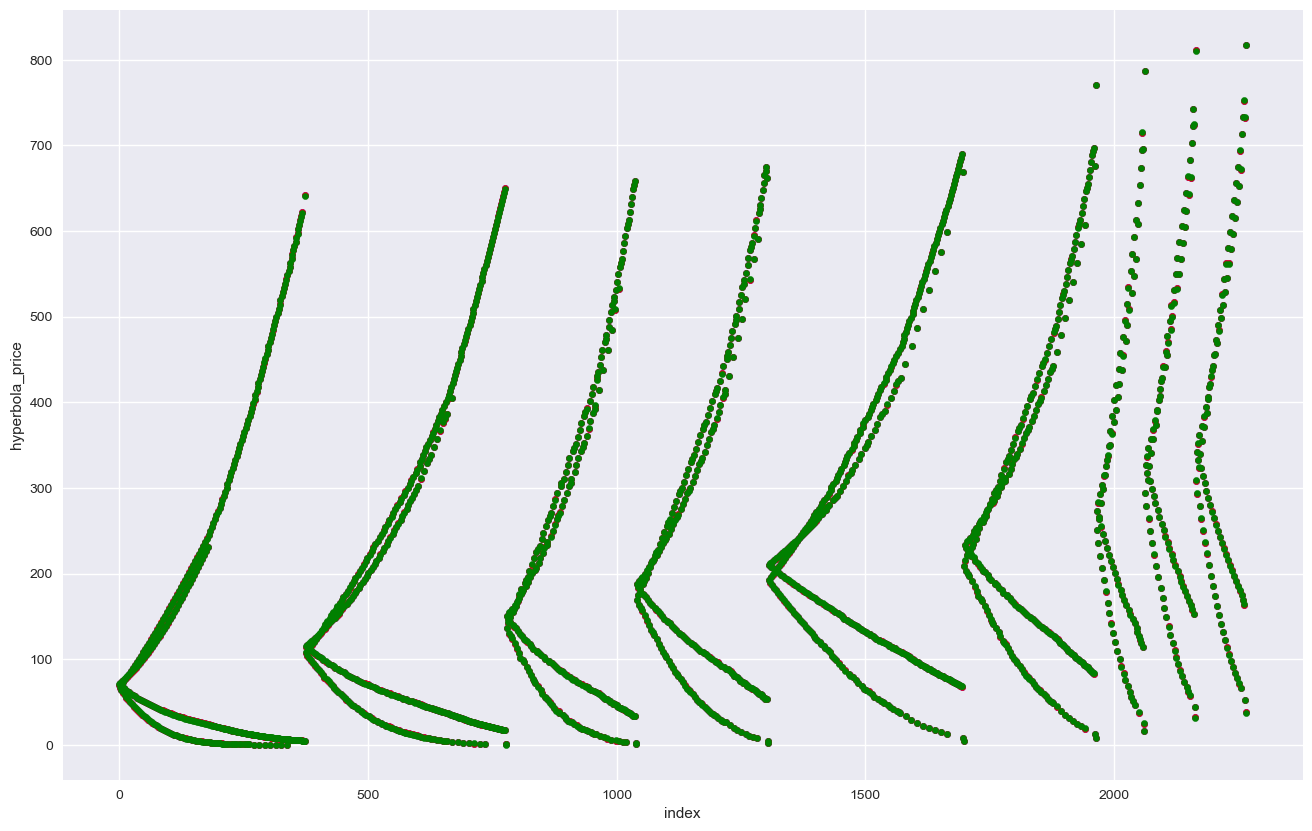

In [22]:
pl = cs_df.copy()
pl = pl.reset_index()
ax = pl.plot(kind="scatter", x="index",y="MID_CLOSE", color="b")
pl.plot(kind="scatter", x="index",y="implied_price", color="r", ax=ax)
pl.plot(kind="scatter", x="index",y="hyperbola_price", color="g", ax=ax)

In [23]:
# vol curve evaluation
p_c = 0.1
loss = (cs_df['IV_MID']-cs_df['hyperbola_vol'])*(cs_df['VEGA']+p_c)
sum(loss)

-0.5033935141288901

In [24]:
sum((cs_df['IV_MID']-cs_df['hyperbola_vol'])**2)

0.0018321059840295671

In [25]:
# see parameters in time-series
ts_list = base_data['TS'].unique()[-300:]

cs_df_list = [None]*len(ts_list)
fit_df_list = [None]*len(ts_list)

for i in range(len(ts_list)):
    ts = ts_list[i]
    print(ts)
    cs_df = base_data[base_data['TS'] == ts].dropna().reset_index(drop=True)
    ATM_vols = cs_df[cs_df["RANK"]==0]
    # compared with atm at same exp
    df = pd.merge(cs_df, ATM_vols[["EXP", "TYPE", "IV_BID", "IV_ASK"]], left_on=["EXP", "TYPE"], right_on=["EXP", "TYPE"], 
                  suffixes=(None, "_ATM"), how="left")
    df["MONEYNESS"] = df["UNDERLYING_PRICE"] - df["STRIKE"]
    df["MONEYNESS_F"] = df["STRIKE"]/df["F_T"]
    df["LOG_MONEYNESS_F"] = np.log(df["MONEYNESS_F"])
    df["LOG_MONEYNESS_F_STANDARD_TIME"] = df["LOG_MONEYNESS_F"] / np.sqrt(df["CAL_DAYS"])

    # df["LOG_MONEYNESS_F_STANDARD_STD"] = df["LOG_MONEYNESS_F"] / (np.sqrt(df["CAL_DAYS"])*(df["IV_BID_ATM"]+df["IV_ASK_ATM"])/2)

    df["IV_BID_DIFF"] = df["IV_BID"] - df["IV_BID_ATM"]
    df["IV_ASK_DIFF"] = df["IV_ASK"] - df["IV_ASK_ATM"]

    df["IV_BID_RATIO"] = df["IV_BID"]/df["IV_BID_ATM"]
    df["IV_ASK_RATIO"] = df["IV_ASK"]/df["IV_ASK_ATM"]
    df["IV_MID_SQR"] = df["IV_MID"]**2
    cs_df = df.copy()
    otm_mask = (((cs_df["TYPE"]=='C') & (cs_df["STRIKE"]>cs_df["UNDERLYING_PRICE"])) 
            | ((cs_df["TYPE"]=='P') & (cs_df["STRIKE"]<=cs_df["UNDERLYING_PRICE"])))

    otm  = cs_df[otm_mask].copy().reset_index(drop=True)
    to_fit = otm
    fits = to_fit.groupby("BUS_DAYS").apply(fit_hyp)
    fits = np.array([v for v in fits.values])

    fit_df = pd.DataFrame(fits, index=to_fit["BUS_DAYS"].unique(), columns=['a', 'b', 'c', 'd', 'e'])
    ttm_list = list(cs_df['BUS_DAYS'].unique())
    for ttm in ttm_list:
        param = fit_df[fit_df.index==ttm].values[0]
        cs_df.loc[cs_df['BUS_DAYS']==ttm,'hyperbola_vol'] = cs_df.loc[cs_df['BUS_DAYS']==ttm,'LOG_MONEYNESS_F'].apply(lambda x:
                                                    np.sqrt(hyperbola(x, param[0], param[1], param[2], param[3], param[4])))
    F = cs_df["F_T"].astype(float).values
    K = cs_df['STRIKE'].astype(float).values
    r = cs_df['RATE'].astype(float).values
    T = cs_df['BUS_DAYS'].astype(float).values/252
    typee = cs_df['TYPE'].values
    h_vol = cs_df['hyperbola_vol'].astype(float).values
    iv = cs_df['IV_MID'].astype(float).values

    cs_df["hyperbola_price"] = black76(F,K,T,r,h_vol,typee)
    cs_df["implied_price"] = black76(F,K,T,r,iv,typee)
    cs_df_list[i] = cs_df
    fit_df_list[i] = fit_df
    

2021-01-25T00:00:00.000000000
2021-01-26T00:00:00.000000000
2021-01-27T00:00:00.000000000
2021-01-28T00:00:00.000000000
2021-01-29T00:00:00.000000000
2021-02-01T00:00:00.000000000
2021-02-02T00:00:00.000000000
2021-02-03T00:00:00.000000000
2021-02-04T00:00:00.000000000
2021-02-05T00:00:00.000000000
2021-02-08T00:00:00.000000000
2021-02-09T00:00:00.000000000
2021-02-10T00:00:00.000000000
2021-02-11T00:00:00.000000000
2021-02-12T00:00:00.000000000
2021-02-16T00:00:00.000000000
2021-02-17T00:00:00.000000000
2021-02-18T00:00:00.000000000
2021-02-19T00:00:00.000000000
2021-02-22T00:00:00.000000000
2021-02-23T00:00:00.000000000
2021-02-24T00:00:00.000000000


KeyboardInterrupt: 

In [32]:
param_df.head(30)

,index,a,b,c,d,e,time,rank
0,18,0.0683,0.0359,0.0333,-0.1607,-0.0168,2021-01-25,1.0
1,38,0.0537,0.0157,0.0460,-0.1565,0.0077,2021-01-25,2.0
2,57,0.0484,0.0105,0.0509,-0.1681,0.0162,2021-01-25,3.0
3,82,0.0548,0.0095,0.0620,-0.1550,0.0190,2021-01-25,4.0
4,101,0.0553,0.0084,0.0675,-0.1501,0.0210,2021-01-25,5.0
5,120,0.0598,0.0084,0.0749,-0.1417,0.0214,2021-01-25,6.0
6,164,0.0631,0.0075,0.0901,-0.1251,0.0223,2021-01-25,7.0
7,228,0.0504,0.0042,0.1015,-0.1177,0.0263,2021-01-25,8.0
8,251,0.0480,0.0037,0.1047,-0.1138,0.0269,2021-01-25,9.0
9,17,0.0731,0.0416,0.0403,-0.1216,-0.0232,2021-01-26,1.0


In [30]:
param_df = pd.DataFrame()
for i in range(len(ts_list)):
    sdf = fit_df_list[i]
    sdf = sdf.reset_index()
    sdf['time'] = ts_list[i]
    sdf['rank'] = sdf['index'].rank()
    param_df = pd.concat([param_df, sdf], ignore_index=True)
param_df
# analysis dimension: rank,index(ttm),time

AttributeError: 'NoneType' object has no attribute 'reset_index'

<AxesSubplot:xlabel='index'>

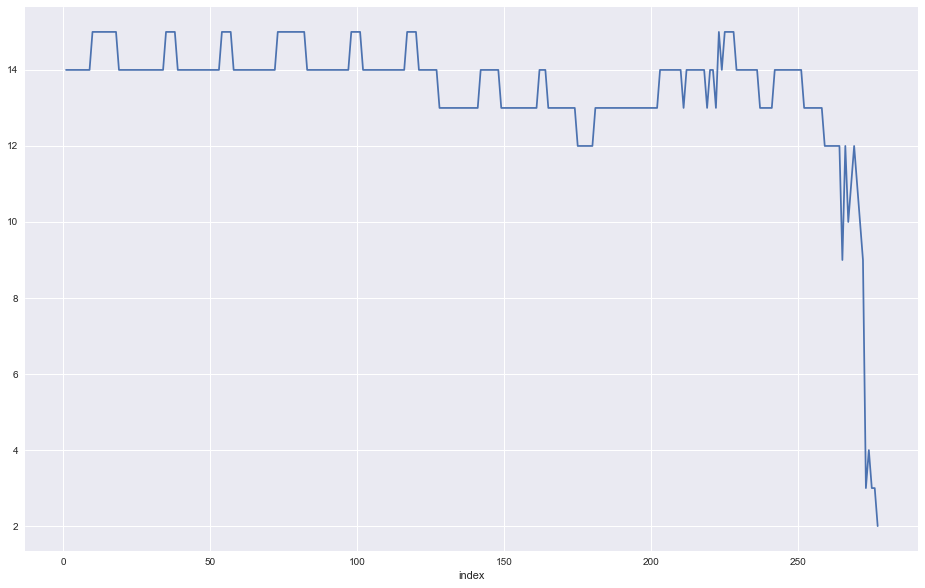

In [92]:
param_df.groupby('index').count()['time'].plot()

In [81]:
param_df.to_excel("ts_param.xlsx")

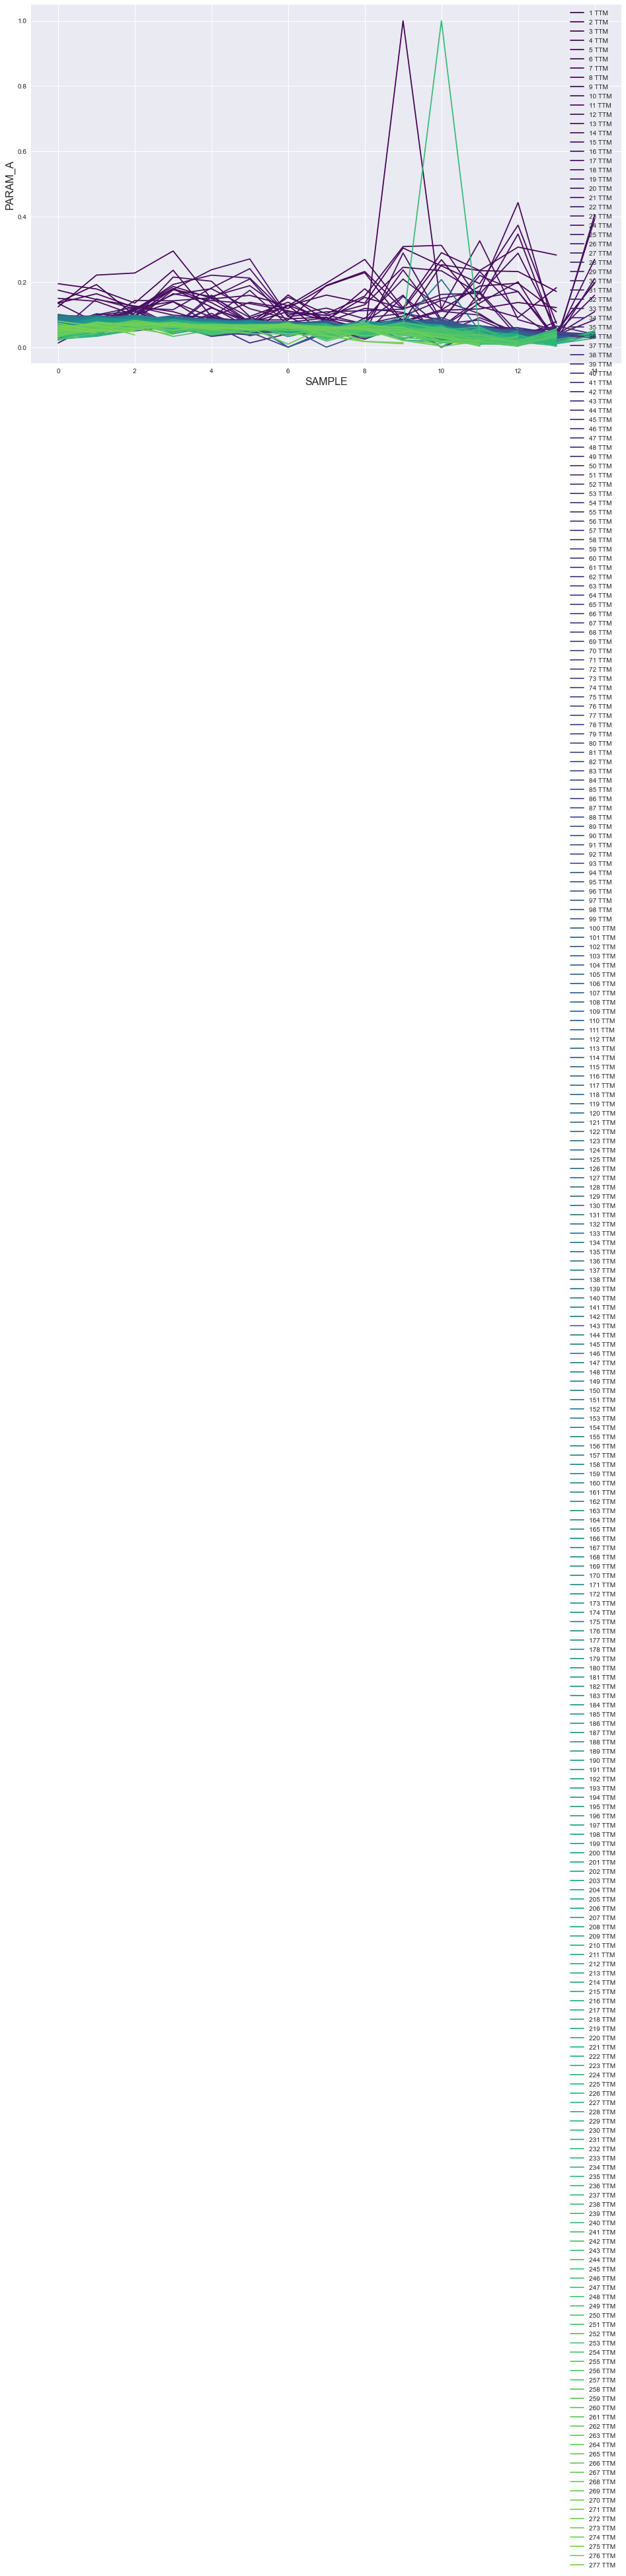

In [111]:
ttm_list = sorted(param_df['index'].unique())
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['a'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_A',size=16)
ax.legend()

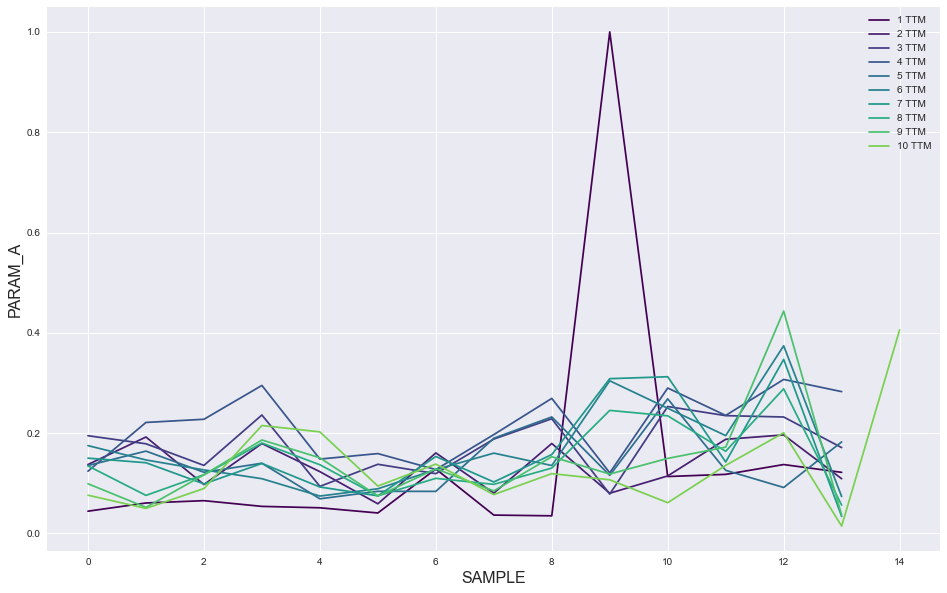

In [114]:
ttm_list = sorted(param_df['index'].unique())[:10]
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['a'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_A',size=16)
ax.legend()

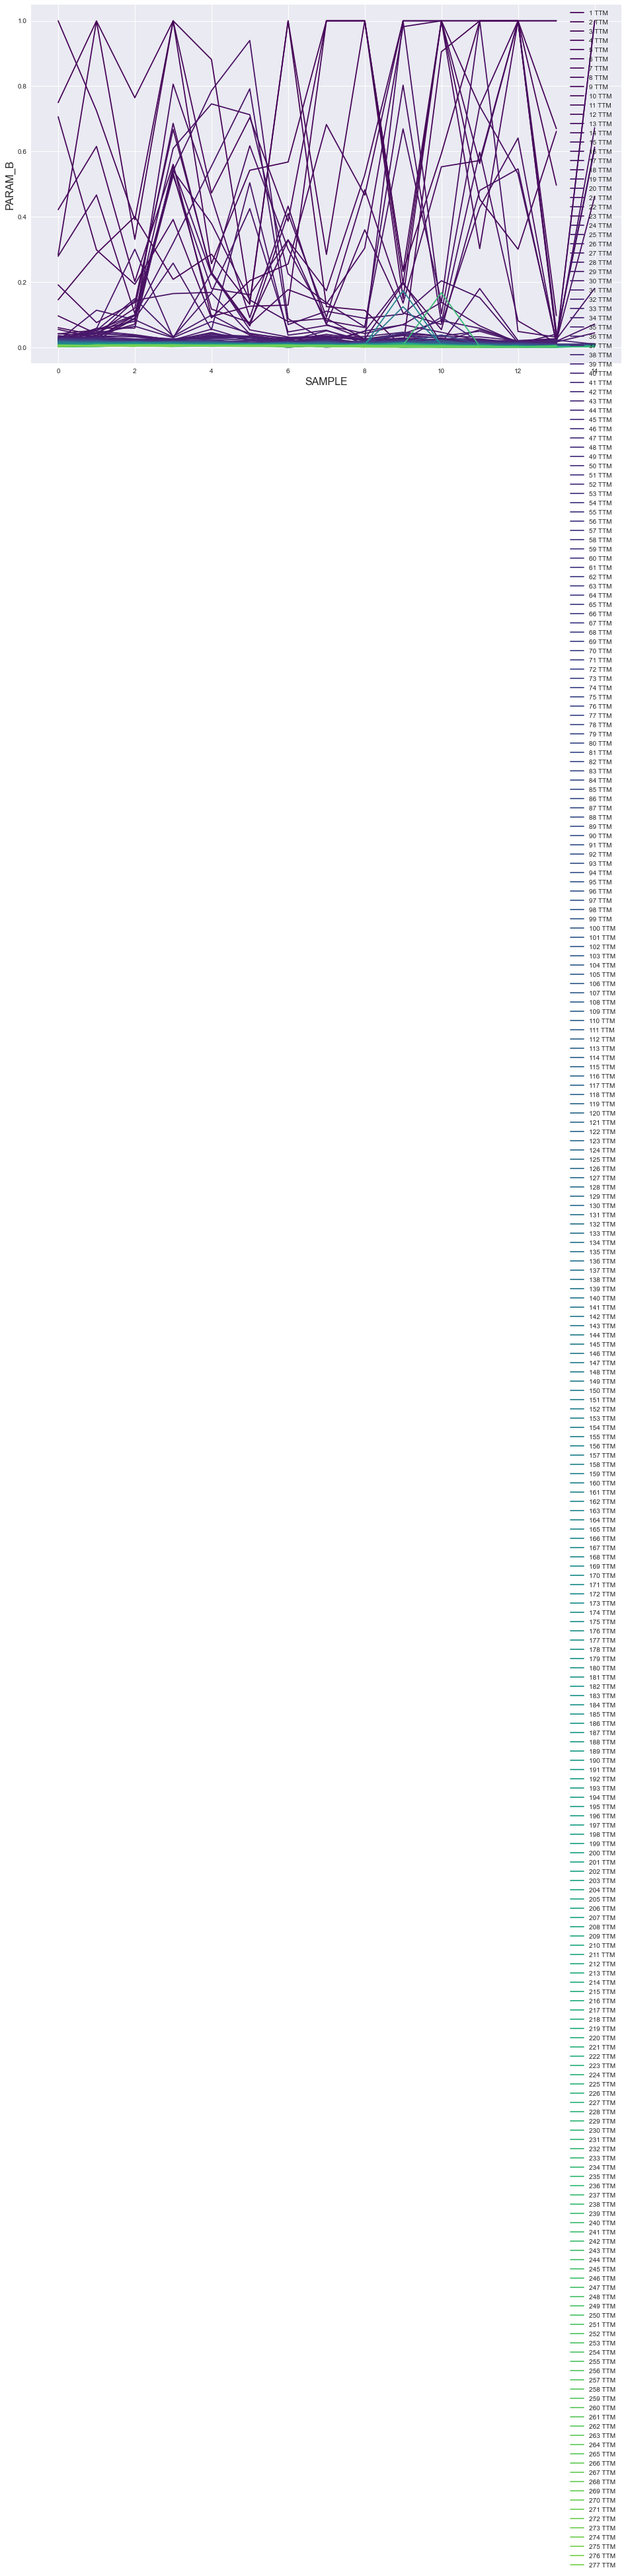

In [112]:
ttm_list = sorted(param_df['index'].unique())
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['b'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_B',size=16)
ax.legend()

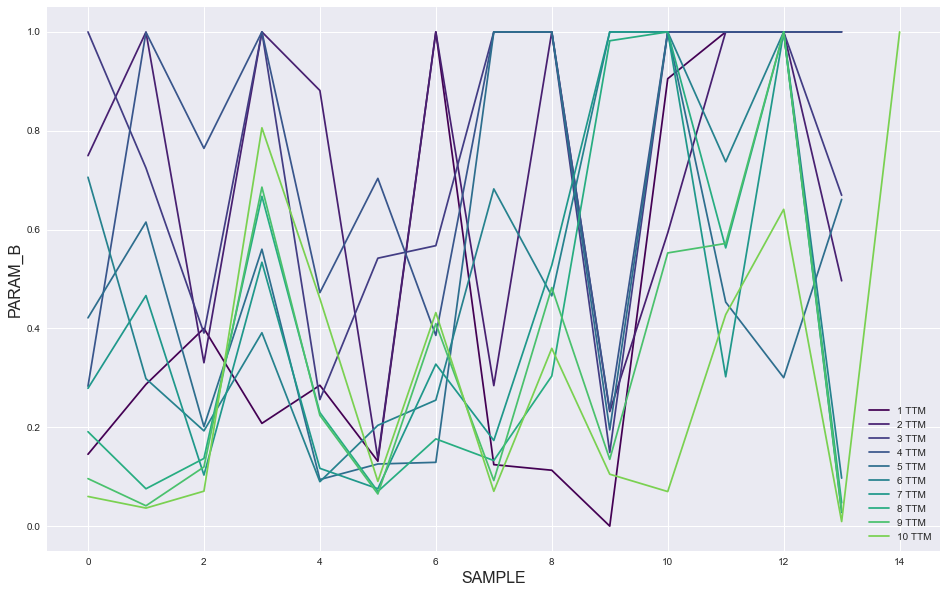

In [115]:
ttm_list = sorted(param_df['index'].unique())[:10]
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['b'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_B',size=16)
ax.legend()

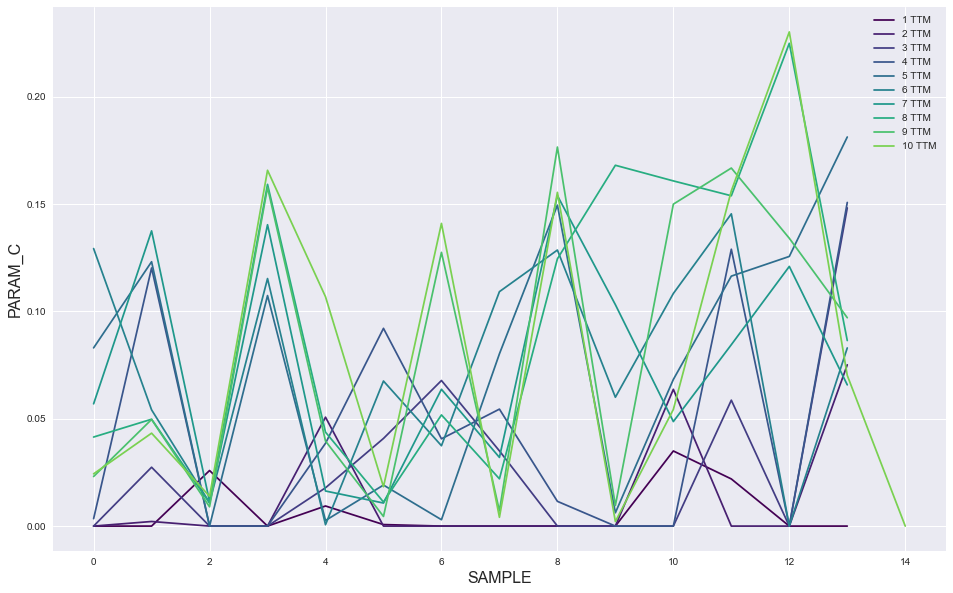

In [116]:
ttm_list = sorted(param_df['index'].unique())[:10]
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['c'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_C',size=16)
ax.legend()

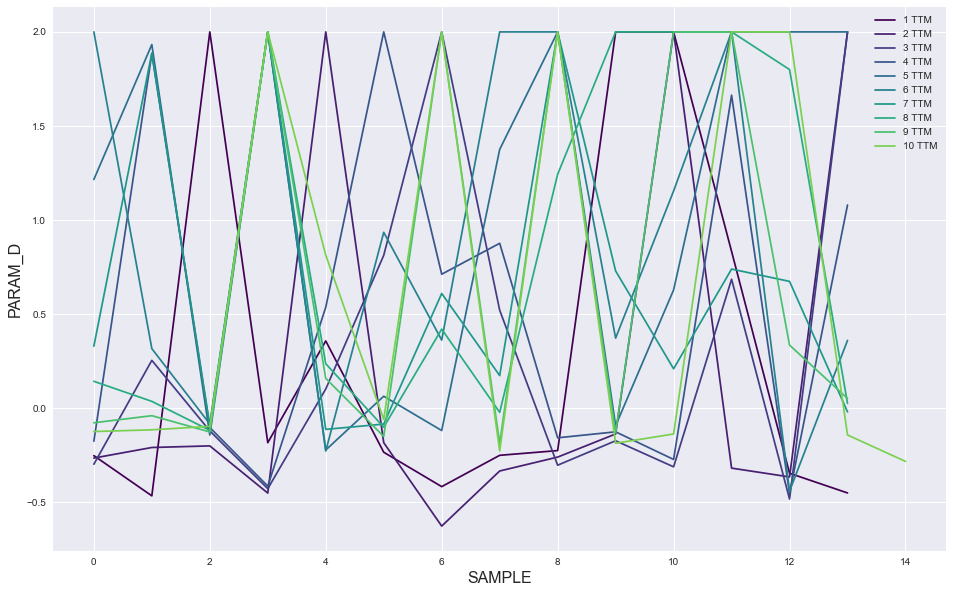

In [117]:
ttm_list = sorted(param_df['index'].unique())[:10]
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['d'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_D',size=16)
ax.legend()

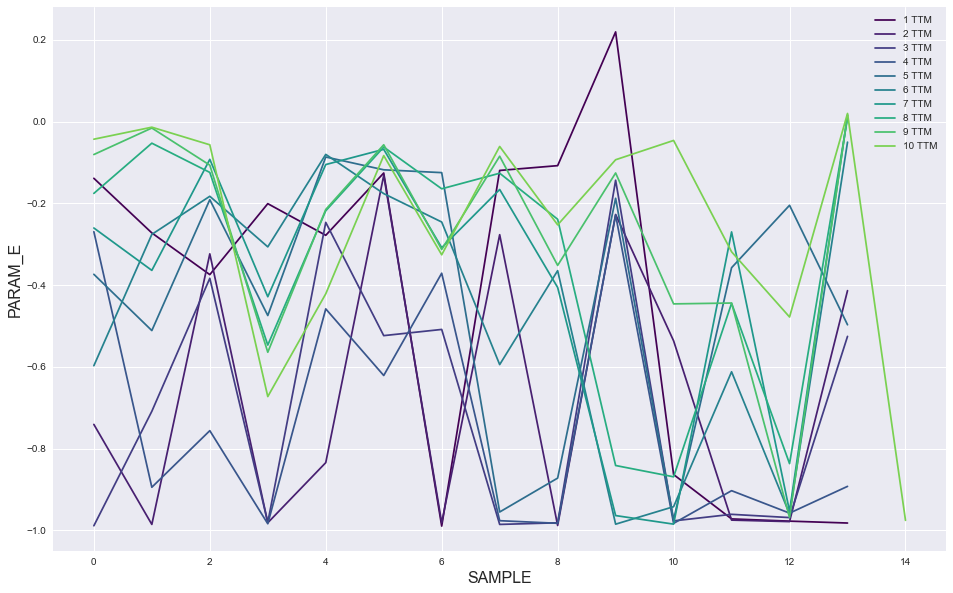

In [118]:
ttm_list = sorted(param_df['index'].unique())[:10]
a_df = pd.DataFrame()
fig, ax = plt.subplots()
colors = cm.viridis(np.linspace(0,0.8,len(ttm_list)))
for i in range(len(ttm_list)):
    df = pd.DataFrame(param_df[param_df['index']==ttm_list[i]]['e'].reset_index(drop=True))
    df.columns = [ttm_list[i]]
    a_df = pd.concat([a_df,df],axis=1)

a_df = a_df.reset_index()
for i in range(len(ttm_list)):
    ax.plot(a_df['index'], a_df[ttm_list[i]], label="{} TTM".format(ttm_list[i]), color=colors[i])
ax.set_xlabel('SAMPLE',size=16)
ax.set_ylabel('PARAM_E',size=16)
ax.legend()

<AxesSubplot:>

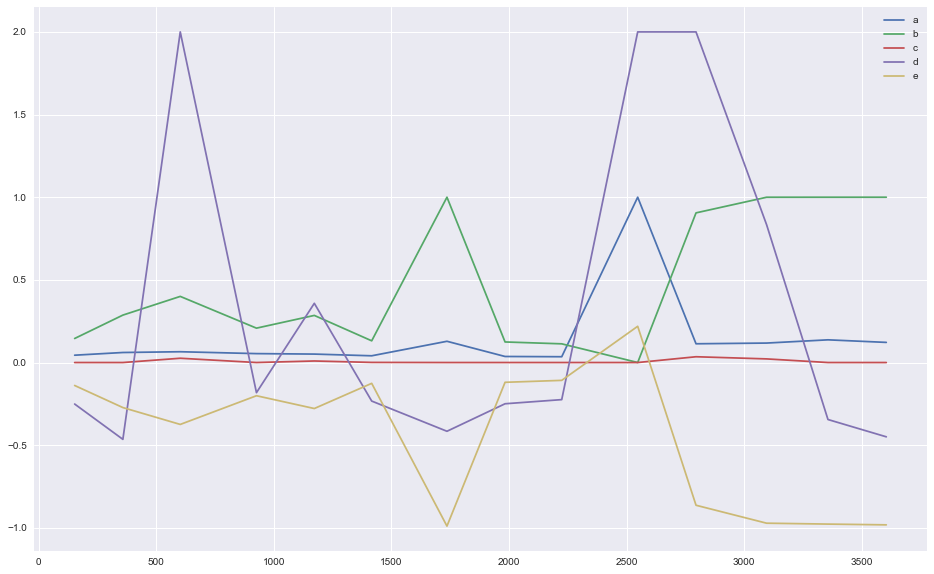

In [83]:
param_df[param_df['index']==1][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

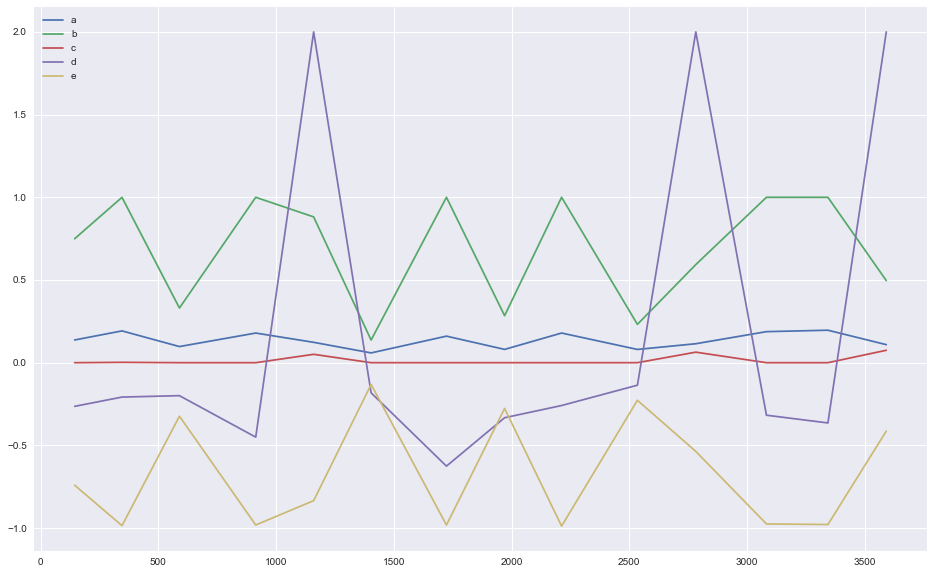

In [93]:
param_df[param_df['index']==2][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

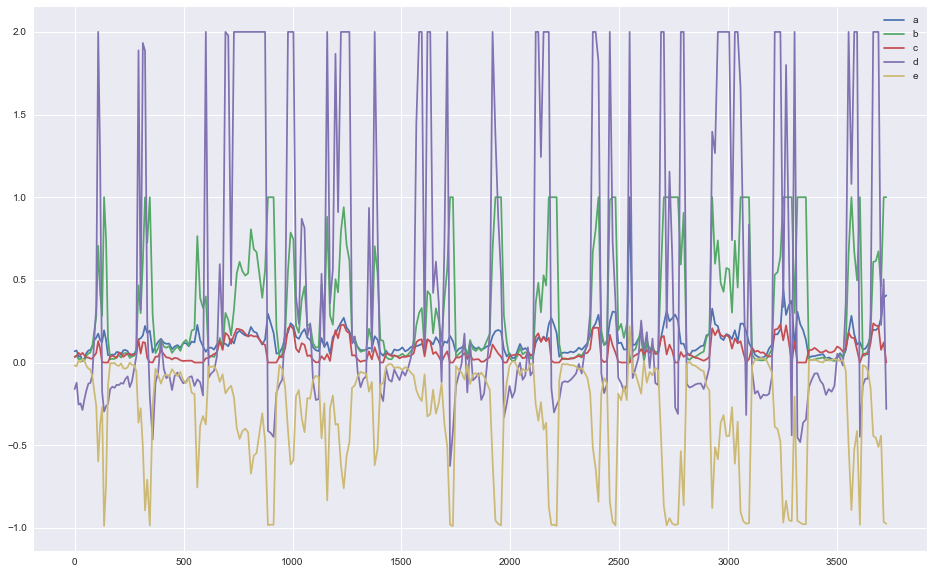

In [84]:
param_df[param_df['rank']==1.][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

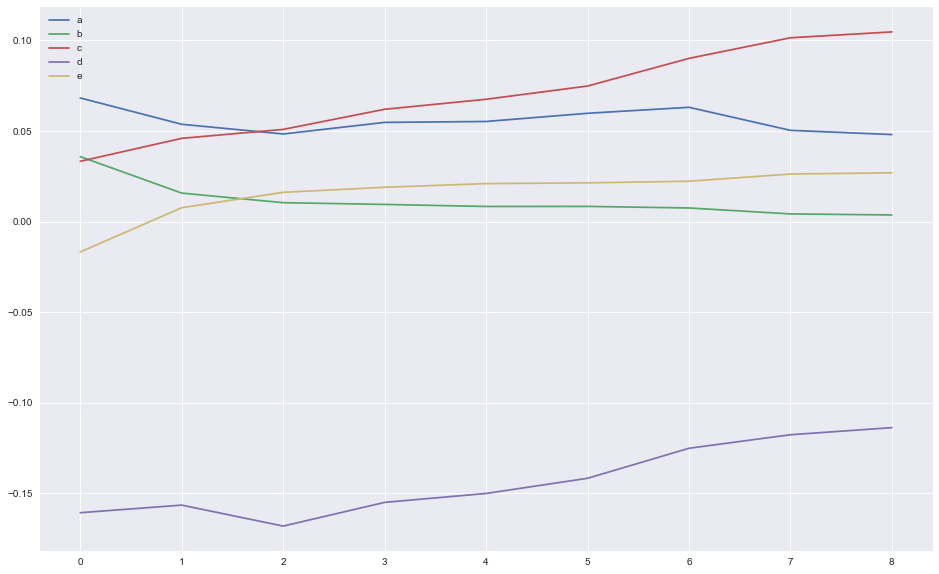

In [86]:
param_df[:9][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

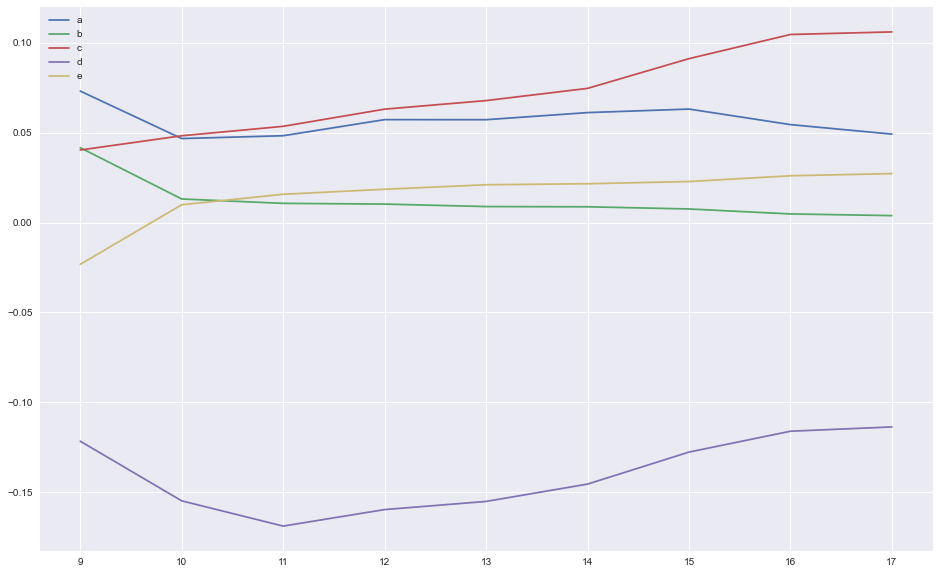

In [89]:
param_df[9:18][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

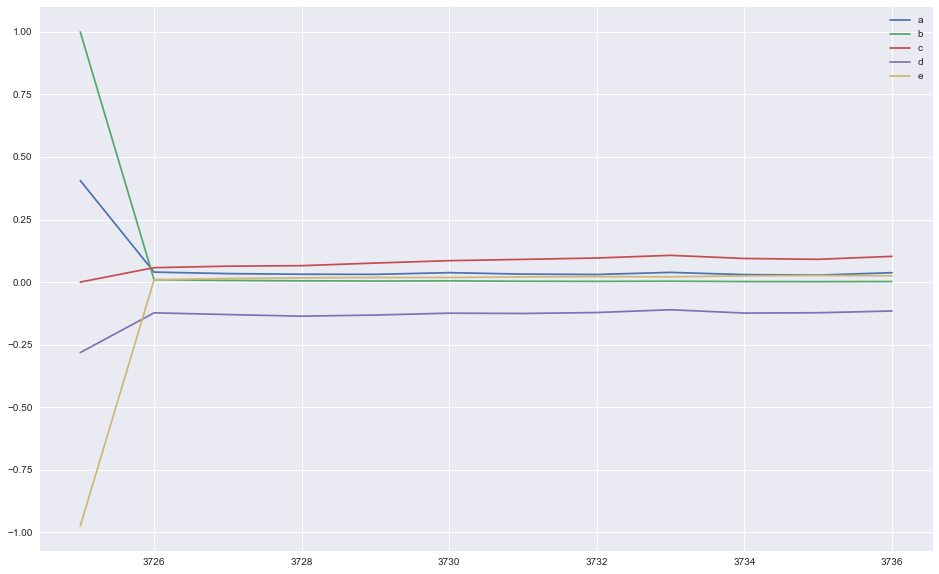

In [87]:
param_df[-12:][['a', 'b', 'c', 'd', 'e']].plot()

<AxesSubplot:>

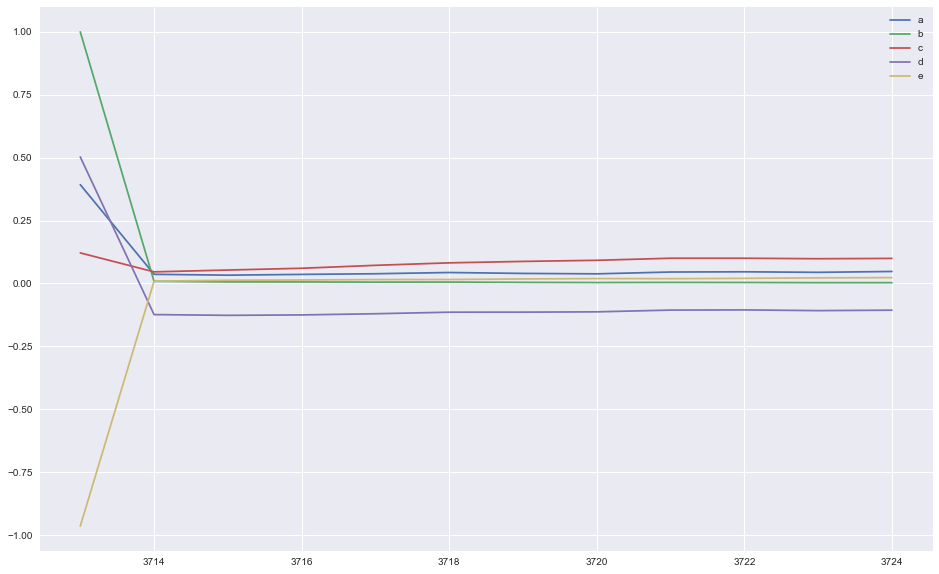

In [88]:
param_df[-24:-12][['a', 'b', 'c', 'd', 'e']].plot()

# 3.vol curve models evaluation
loss function/evaluation standard:

$$\begin{aligned}
    ((iv_{mid} - iv_{fitted})*(vega+C))^2
\end{aligned}$$

We want to predict the best vol curve parameters in the following parts.

# 4. parameter prediction

If we can link the parameters in different expirations, then the base data is a T*5 time series matrix, then we utilize various ways to predict this data.

* evaluation standard: Pearson Correlation

## 4.1 multiple time series prediction on parameters
* ARMA, VARMA, GARCH, Kalman Enhancer, LSTM, LightGBM, ...

## 4.2 build cross-sectional features for prediction

## 4.3 merge features together(feature engineering)
* OLS, Trees, Neural Network, Reinforce Learning, ...

In [ ]:
def feature_avg(df, columns, weight=False):
    if not weight:
        features = df[columns].mean()
        return features
    
    else:
        wt = df[weight]
        features = df[columns].T @ wt / wt.sum()
        return features
    
def feature_cross_corr(features, parameters=fit_data):
    f_col = features.columns
    p_col = parameters.columns
    features = features.reset_index()
    parameters = parameters.shift(-1).reset_index().rename(columns={"index":"TS"})
    new_data = pd.merge(features, parameters,on="TS", how="left")
    new_data = new_data.dropna().set_index("TS")
    return new_data.corr().loc[f_col, p_col]